## Calories Burned Predictor

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder 

from xgboost import XGBRegressor

In [5]:
# Reading in data

calories = pd.read_csv("calories.csv")
exercise = pd.read_csv("exercise.csv")

In [6]:
calories.head()

,User_ID,Calories
0,14733363,231.0
1,14861698,66.0
2,11179863,26.0
3,16180408,71.0
4,17771927,35.0


In [7]:
exercise.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8


In [8]:
gym = pd.merge(calories, exercise)
gym.head()

,User_ID,Calories,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,14733363,231.0,male,68,190.0,94.0,29.0,105.0,40.8
1,14861698,66.0,female,20,166.0,60.0,14.0,94.0,40.3
2,11179863,26.0,male,69,179.0,79.0,5.0,88.0,38.7
3,16180408,71.0,female,34,179.0,71.0,13.0,100.0,40.5
4,17771927,35.0,female,27,154.0,58.0,10.0,81.0,39.8


In [9]:
gym.shape

(15000, 9)

In [10]:
gym_summary = gym.drop(columns = 'User_ID')

round(gym_summary.describe(), 2)

,Calories,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
count,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00
mean,89.54,42.79,174.47,74.97,15.53,95.52,40.03
std,62.46,16.98,14.26,15.04,8.32,9.58,0.78
min,1.00,20.00,123.00,36.00,1.00,67.00,37.10
25%,35.00,28.00,164.00,63.00,8.00,88.00,39.60
50%,79.00,39.00,175.00,74.00,16.00,96.00,40.20
75%,138.00,56.00,185.00,87.00,23.00,103.00,40.60
max,314.00,79.00,222.00,132.00,30.00,128.00,41.50


In [11]:
# Converting kg to lbs
gym['Weight'] = gym['Weight'] * 2.205

# Converting cm to inch
gym['Height'] = gym['Height'] / 2.54

# Converting Celsius to Fahrenheit
gym['Body_Temp'] = gym['Body_Temp'] * (9/5) + 32

In [12]:
gym.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Calories    15000 non-null  float64
 2   Gender      15000 non-null  object 
 3   Age         15000 non-null  int64  
 4   Height      15000 non-null  float64
 5   Weight      15000 non-null  float64
 6   Duration    15000 non-null  float64
 7   Heart_Rate  15000 non-null  float64
 8   Body_Temp   15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.1+ MB


In [13]:
gym.isnull().sum()

User_ID       0
Calories      0
Gender        0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
dtype: int64

<AxesSubplot:xlabel='Gender', ylabel='count'>

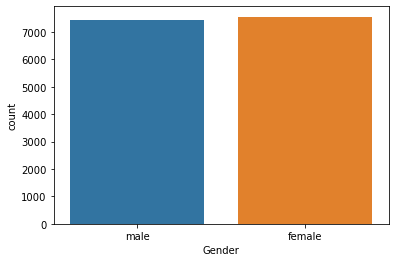

In [14]:
# Initial Plots

sns.countplot(x='Gender', data = gym)

/Users/rickzheng/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/rickzheng/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/rickzheng/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

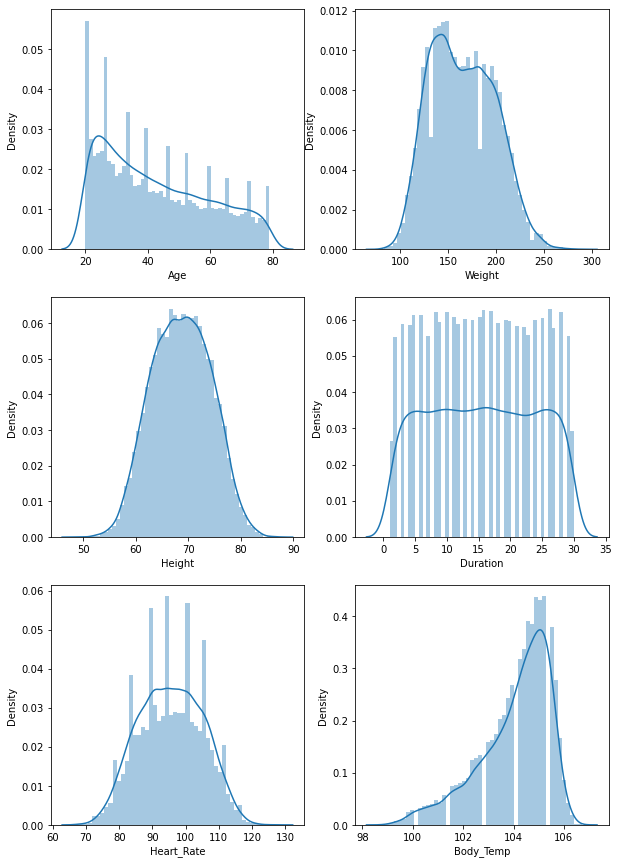

In [15]:
distplot_features = ['Age','Weight', 'Height', 'Duration', 'Heart_Rate', 'Body_Temp']

fig, ax = plt.subplots(3, 2, figsize=(10, 15))

for i, feature in enumerate(distplot_features):
    sns.distplot(gym[feature], bins=50, ax=ax[i//2, i%2])
plt.show()

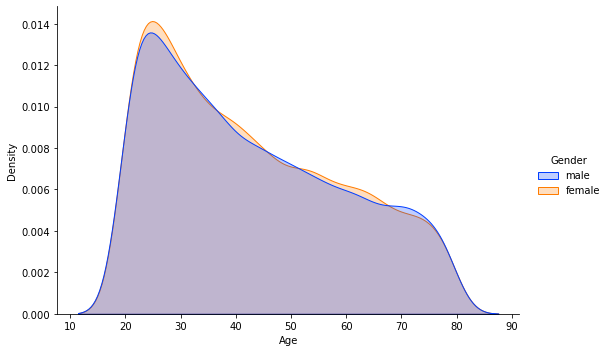

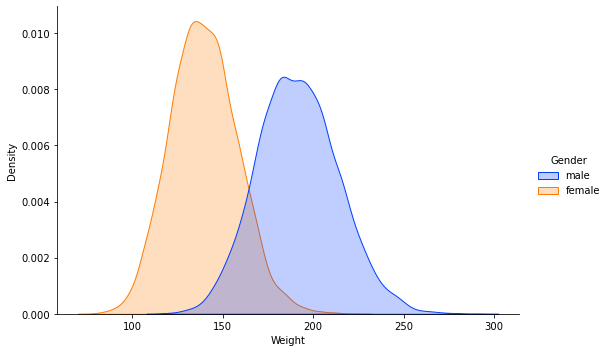

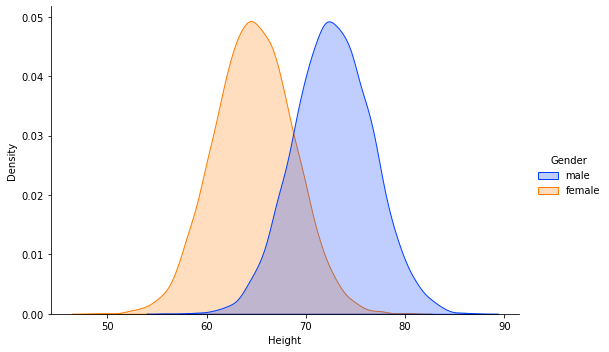

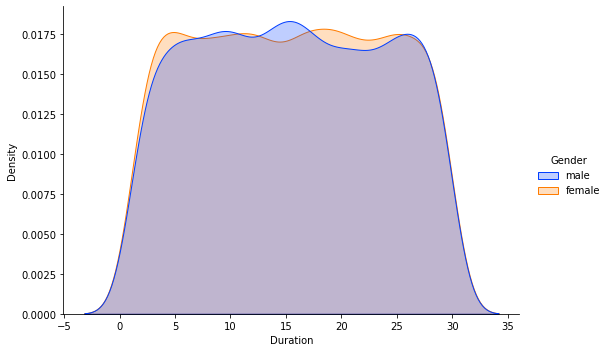

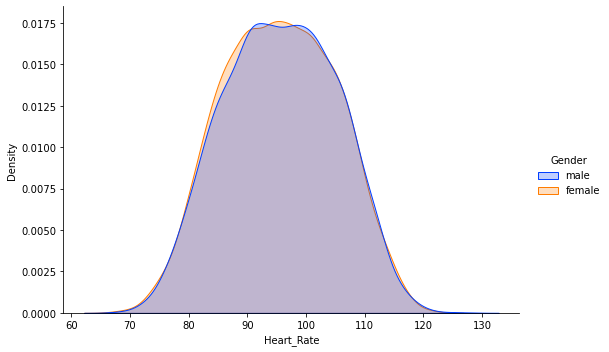

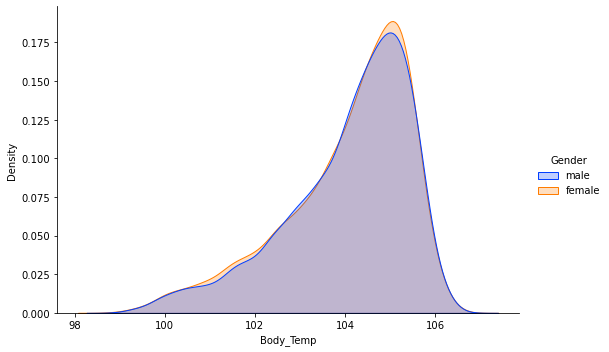

In [16]:
for feature in distplot_features:
    sns.displot(data = gym, x = feature, hue='Gender', kind='kde', fill=True, 
            palette = sns.color_palette('bright')[:2], height=5, aspect=1.5)

### Data Cleaning

In [17]:
gym['Gender'] = gym['Gender'].str.replace("male", "Male")
gym['Gender'] = gym['Gender'].str.replace("feMale", "Female")

In [18]:
# Changing age to bins 

# 1) Early adulthood (20 to 30 years)
# 2) Middle adulthood (30 to 45 years)
# 3) Late adulthood (45 to 60 years) 
# 4) Senior (60+)

#My resource
#https://www.fsps.muni.cz/emuni/data/reader/book-19/04.html

gym['Age'] = gym['Age'].astype(float)

In [19]:
bins = [20, 30, 45, 60, 80]
bin_labels = ['Early Adulthood', 'Middle Adulthood', 'Late Adulthood', 'Senior']

# create a new age column
gym['Age'] = pd.cut(gym['Age'], bins, labels = bin_labels, right = False)

In [20]:
gym['Age'].value_counts()

Middle Adulthood    4393
Early Adulthood     4387
Late Adulthood      3127
Senior              3093
Name: Age, dtype: int64

In [21]:
gym['Age'].value_counts(normalize=True).round(2)

Middle Adulthood    0.29
Early Adulthood     0.29
Late Adulthood      0.21
Senior              0.21
Name: Age, dtype: float64

In [22]:
gym.head()

,User_ID,Calories,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,14733363,231.0,Male,Senior,74.803150,207.270,29.0,105.0,105.44
1,14861698,66.0,Female,Early Adulthood,65.354331,132.300,14.0,94.0,104.54
2,11179863,26.0,Male,Senior,70.472441,174.195,5.0,88.0,101.66
3,16180408,71.0,Female,Middle Adulthood,70.472441,156.555,13.0,100.0,104.90
4,17771927,35.0,Female,Early Adulthood,60.629921,127.890,10.0,81.0,103.64


### Exploratory Data Analysis

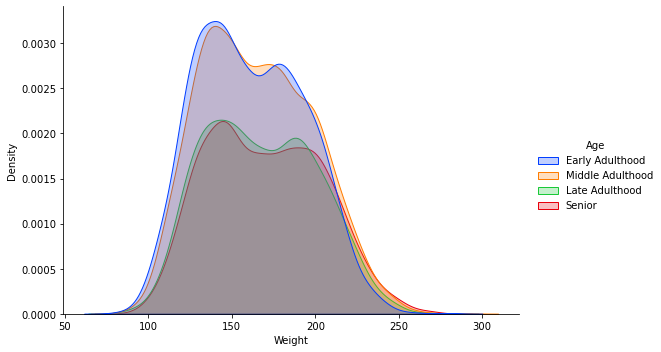

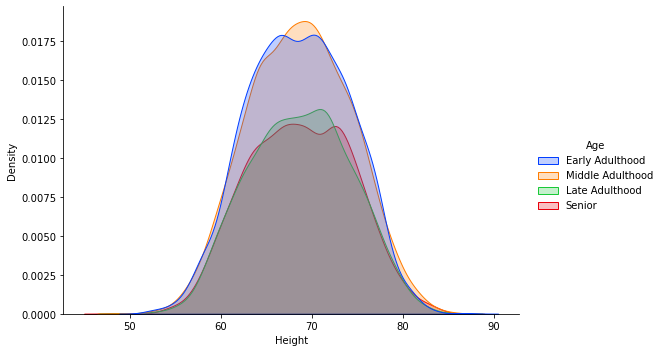

In [23]:
cont_features = ['Weight', 'Height']

for feature in cont_features:
    sns.displot(data = gym, x = feature, hue='Age', kind='kde', fill=True, 
            palette = sns.color_palette('bright')[:4], height=5, aspect=1.5)

In [24]:
#making two groups based on new density information

# two groups: Adult, Late Adulthood

char_to_replace = {'Early Adulthood': 'Adulthood', 'Middle Adulthood': 'Adulthood', 
                   'Late Adulthood': 'Late Adulthood', 'Senior': 'Late Adulthood'}

# Iterate over all key-value pairs in dictionary 
for key, value in char_to_replace.items():
    # Replace key character with value character in string
     gym['Age'] = gym['Age'].replace(key, value)

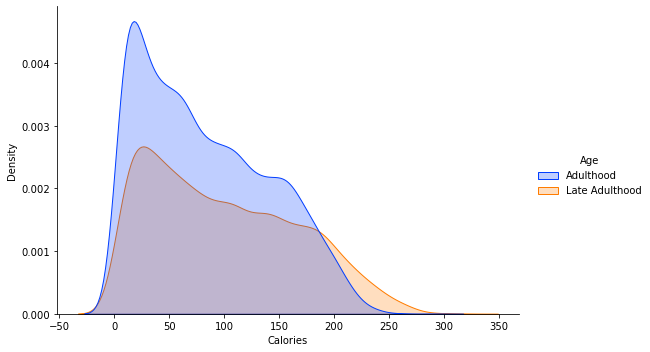

In [25]:
sns.displot(data = gym, x = 'Calories', hue='Age', kind='kde', fill=True, 
            palette = sns.color_palette('bright')[:2], height=5, aspect=1.5)

In [47]:
# scatterplots using altair with color by age and gender
import altair as alt

plt.figure(figsize = (10,7))

alt.data_transformers.disable_max_rows()

x = alt.Chart(gym).mark_circle(opacity = 0.2).encode(
    alt.X('Height', scale=alt.Scale(domain=(40, 95))),
    alt.Y('Weight'),
    color="Gender"
)

x.save('ht_wt.html')

<Figure size 720x504 with 0 Axes>

In [27]:
## correlation plot

corr_visual = gym_summary.corr().drop('Calories').sort_values('Calories',ascending=False)['Calories']
pd.DataFrame({"Features": corr_visual.index, "Calories_Correlation": corr_visual.values}).style.background_gradient(cmap = 'Reds')

,Features,Calories_Correlation
0,Duration,0.955421
1,Heart_Rate,0.897882
2,Body_Temp,0.824558
3,Age,0.154395
4,Weight,0.035481
5,Height,0.017537


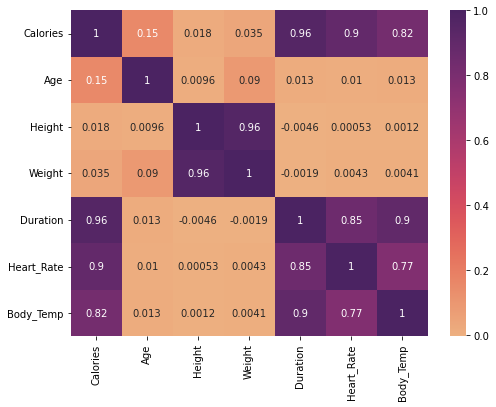

In [28]:
plt.figure(figsize=(8,6))
correlation_visual = sns.heatmap(gym_summary.corr(),annot=True,cmap="flare")

### Feature Engineering

In [29]:
gym.head()

,User_ID,Calories,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,14733363,231.0,Male,Late Adulthood,74.803150,207.270,29.0,105.0,105.44
1,14861698,66.0,Female,Adulthood,65.354331,132.300,14.0,94.0,104.54
2,11179863,26.0,Male,Late Adulthood,70.472441,174.195,5.0,88.0,101.66
3,16180408,71.0,Female,Adulthood,70.472441,156.555,13.0,100.0,104.90
4,17771927,35.0,Female,Adulthood,60.629921,127.890,10.0,81.0,103.64


In [30]:
from sklearn.preprocessing import LabelEncoder

gender_encoder = LabelEncoder()
gender_encoder.fit(gym['Gender'])
gender_values = gender_encoder.transform(gym['Gender'])

print("Before Encoding:", list(gym['Gender'][-10:]))
print("After Encoding:", gender_values[-10:])

age_encoder = LabelEncoder()
age_encoder.fit(gym['Age'])
age_values = age_encoder.transform(gym['Age'])

print("Before Encoding:", list(gym['Age'][-10:]))
print("After Encoding:", age_values[-10:])

Before Encoding: ['Female', 'Male', 'Male', 'Male', 'Female', 'Female', 'Female', 'Female', 'Male', 'Male']
After Encoding: [0 1 1 1 0 0 0 0 1 1]
Before Encoding: ['Adulthood', 'Late Adulthood', 'Adulthood', 'Late Adulthood', 'Late Adulthood', 'Adulthood', 'Adulthood', 'Adulthood', 'Late Adulthood', 'Late Adulthood']
After Encoding: [0 1 0 1 1 0 0 0 1 1]


In [31]:
gender_df = pd.DataFrame(gender_values, columns = ['Biological Sex'])
age_df = pd.DataFrame(age_values, columns = ['Age Group'])

combined = pd.concat([gym, gender_df, age_df], axis = 1)

df = combined.drop(columns = ['Gender', 'Age'])
df.head()

,User_ID,Calories,Height,Weight,Duration,Heart_Rate,Body_Temp,Biological Sex,Age Group
0,14733363,231.0,74.803150,207.270,29.0,105.0,105.44,1,1
1,14861698,66.0,65.354331,132.300,14.0,94.0,104.54,0,0
2,11179863,26.0,70.472441,174.195,5.0,88.0,101.66,1,1
3,16180408,71.0,70.472441,156.555,13.0,100.0,104.90,0,0
4,17771927,35.0,60.629921,127.890,10.0,81.0,103.64,0,0


In [32]:
X = df.drop(columns = ['Calories', 'User_ID'])
Y = df['Calories']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 123)

### Modeling

In [34]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [35]:
# Application of Multiple Linear Regression

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
mae_lr=metrics.mean_absolute_error(y_test, y_pred_lr)
mse_lr=metrics.mean_squared_error(y_test, y_pred_lr)

# Printing the metrics
print('R2:',metrics.r2_score(y_test, y_pred_lr))
print('MAE: ', mae_lr)
print('MSE: ', mse_lr)

R2: 0.9610867450440825
MAE:  9.106410457350703
MSE:  151.49184957899735


In [36]:
# Application of Decision Tree Regression

dt = DecisionTreeRegressor(random_state = 123)
dt.fit(X_train,y_train)

y_pred_dt = dt.predict(X_test)

mae_dt=metrics.mean_absolute_error(y_test, y_pred_dt)
mse_dt=metrics.mean_squared_error(y_test, y_pred_dt)

# Printing the metrics
print('R2:',metrics.r2_score(y_test, y_pred_dt))
print('MAE: ', mae_dt)
print('MSE: ', mse_dt)

R2: 0.9808232525964439
MAE:  5.605666666666667
MSE:  74.65633333333334


In [37]:
# Application of Random Forest Regression

rf = RandomForestRegressor(random_state = 123)
rf.fit(X_train,y_train)

y_pred_rf = rf.predict(X_test)
mae_rf=metrics.mean_absolute_error(y_test, y_pred_rf)
mse_rf=metrics.mean_squared_error(y_test, y_pred_rf)

# Printing the metrics
print('R2:',metrics.r2_score(y_test, y_pred_rf))
print('MAE: ', mae_rf)
print('MSE: ', mse_rf)

R2: 0.9899104049115008
MAE:  4.211821444444444
MSE:  39.279454345092596


In [38]:
# Application of Support Vector Regression

sv = SVR()
sv.fit(X_train,y_train)
y_pred_sv=sv.predict(X_test)

mae_sv=metrics.mean_absolute_error(y_test, y_pred_sv)
mse_sv=metrics.mean_squared_error(y_test, y_pred_sv)

# Printing the metrics
print('R2:',metrics.r2_score(y_test, y_pred_sv))
print('MAE: ', mae_sv)
print('MSE: ', mse_sv)

R2: 0.898109957919516
MAE:  13.763985739798501
MSE:  396.6646055679585


In [39]:
compare_model = {'Model': ['Multiple Linear Regression', 'Decision Tree',
                           'Random Forest','Support Vector Machine'],
                 'Mean Absolute Error': [mae_lr, mae_dt, mae_rf, mae_sv],
                 'Mean Squared Error': [mse_lr, mse_dt, mse_rf, mse_sv],
                 'R2': [metrics.r2_score(y_test, y_pred_lr), 
                                     metrics.r2_score(y_test, y_pred_dt),
                                     metrics.r2_score(y_test, y_pred_rf),
                                     metrics.r2_score(y_test, y_pred_sv)]
                }

model_type = pd.DataFrame(compare_model)
final_models = model_type.sort_values('R2', ascending = False).reset_index(drop = True).round(2)
final_models

,Model,Mean Absolute Error,Mean Squared Error,R2
0,Random Forest,4.21,39.28,0.99
1,Decision Tree,5.61,74.66,0.98
2,Multiple Linear Regression,9.11,151.49,0.96
3,Support Vector Machine,13.76,396.66,0.90


In [40]:
X.columns

Index(['Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp',
       'Biological Sex', 'Age Group'],
      dtype='object')

In [41]:
def predict_cals(ht, wt, duration, heart_rate, body_temp, sex, age): 

    feature = np.zeros(len(X.columns))

    feature[0] = ht
    feature[1] = wt
    feature[2] = duration
    feature[3] = heart_rate
    feature[4] = body_temp
    if sex == 'Female':
        feature[5] = 0
    if sex == 'Male':
        feature[5] = 1
    if age == 'Adulthood':
        feature[6] = 0
    if age == 'Late Adulthood':
        feature[6] = 1

    return rf.predict([feature])[0]

In [42]:
predict_cals(75, 150, 50, 115, 40, "Male", 'Adulthood')

/Users/rickzheng/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


218.52